In [16]:
from os import listdir
from os.path import isfile, join

import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage

from segmentation_models import PSPNet
from segmentation_models import FPN
from segmentation_models import Unet
from segmentation_models import Linknet
from segmentation_models.segmentation_models.backbones import get_preprocessing

from keras import backend as K
import keras

import spacexyz
%load_ext autoreload
%autoreload 2

K.tensorflow_backend._get_available_gpus()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

## Set Parameters

In [17]:
train_image_path = "../train_images/"
train_label_path = "../train_labels/"
val_image_path = "../val_images"
val_label_path = "../val_labels"

n_classes = 1+6

input_size = (512, 512, 3)
output_size = (512, 512)

# Unet, PSPNet, FPN, Linknet
model_name = 'Unet'

# vgg16, vgg19, resnet18, resnet34, resnet50, resnet101, resnet152, resnext50, resnext101, densenet121, densenet169, densenet201, inceptionv3, inceptionresnetv2
backbone_name = 'resnet34'

# number of 10 epoches between saving models
n_save = 5
epc_num = 10

# TODO to resize back the image

## Prepare dataset

In [18]:
####################################################
############# Read in files ########################
####################################################

train_images = spacexyz.path2filelist(train_image_path)
train_labels = spacexyz.path2filelist(train_label_path)
val_images = spacexyz.path2filelist(val_image_path)
val_labels = spacexyz.path2filelist(val_label_path)

assert(len(train_images) == len(train_labels))
assert(len(val_images) == len(val_labels))

n_training = len(train_images)
n_val = len(val_images)
print("Number of training images: ", n_training)
print("Number of validation or testing images: ", n_val)

# initialize data
X_train = np.zeros([n_training, *input_size]).astype(np.uint8)
y_train = np.zeros([n_training, *output_size]).astype(np.uint8)

X_val = np.zeros([n_val, *input_size]).astype(np.uint8)
y_val = np.zeros([n_val, *output_size]).astype(np.uint8)


####################################################
############# Read in training dataset #############
####################################################

train_size = np.zeros([n_training, 2])
val_size = np.zeros([n_val, 2])

print("reading in ", n_training, " training samples...")
for i in range(n_training):
    print(i, end='.')
    t_image = cv2.imread(join(train_image_path, train_images[i]))
    t_label = cv2.imread(join(train_label_path, train_labels[i]))
    print(t_image.shape[:2])
    train_size[i,:] = t_image.shape[:2]
    X_train[i,:,:,:] = cv2.resize(t_image, input_size[:2])
    y_train[i,:,:] = cv2.resize(t_label[:,:,0], output_size[:2], interpolation=cv2.INTER_NEAREST)

    
y_train = keras.utils.to_categorical(y_train, num_classes=n_classes, dtype='float32')


####################################################
############# Read in validation dataset ###########
####################################################

print("reading in ", n_val, " eval samples...")
for i in range(n_val):
    print(i,end= '.')
    v_image = cv2.imread(join(val_image_path, val_images[i]))
    v_label = cv2.imread(join(val_label_path, val_labels[i]))
    val_size[i,:] = v_image.shape[:2]
    X_val[i,:,:,:] = cv2.resize(v_image, input_size[:2])
    y_val[i,:,:] = cv2.resize(v_label[:,:,0], output_size[:2], interpolation=cv2.INTER_NEAREST)
y_val = keras.utils.to_categorical(y_val, num_classes=n_classes, dtype='float32')

Number of training images:  1620
Number of validation or testing images:  20
reading in  1620  training samples...
0.(2227, 2218)
1.(2227, 2218)
2.(905, 1094)
3.(905, 1094)
4.(905, 1094)
5.(905, 1094)
6.(905, 1094)
7.(905, 1094)
8.(905, 1094)
9.(905, 1094)
10.(905, 1094)
11.(905, 1094)
12.(905, 1094)
13.(905, 1094)
14.(905, 1094)
15.(905, 1094)
16.(905, 1094)
17.(905, 1094)
18.(905, 1094)
19.(905, 1094)
20.(905, 1094)
21.(905, 1094)
22.(1229, 1318)
23.(1229, 1318)
24.(1229, 1318)
25.(1229, 1318)
26.(1229, 1318)
27.(1229, 1318)
28.(1229, 1318)
29.(1229, 1318)
30.(1229, 1318)
31.(1229, 1318)
32.(1229, 1318)
33.(1229, 1318)
34.(1229, 1318)
35.(1229, 1318)
36.(1229, 1318)
37.(1229, 1318)
38.(1229, 1318)
39.(1229, 1318)
40.(1229, 1318)
41.(1229, 1318)
42.(1506, 1298)
43.(1506, 1298)
44.(1506, 1298)
45.(1506, 1298)
46.(1506, 1298)
47.(1506, 1298)
48.(1506, 1298)
49.(1506, 1298)
50.(1506, 1298)
51.(1506, 1298)
52.(1506, 1298)
53.(1506, 1298)
54.(1506, 1298)
55.(1506, 1298)
56.(1506, 1298)
57.

## Model training

In [ ]:
####################################################
############# Preprocess data ######################
####################################################

preprocessing_fn = get_preprocessing('resnet34')
x = preprocessing_fn(X_train)

## callback function to evaluate test data at the end of each training epoch

class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

####################################################
############# Set model parameters #################
####################################################

if model_name == 'Unet':
    model = Unet(backbone_name=backbone_name, classes=n_classes, activation='softmax')
elif model_name == 'PSPNet':
    model = PSPNet(backbone_name=backbone_name, classes=n_classes, activation='softmax')
elif model_name == 'FPN':
    model = FPN(backbone_name=backbone_name, classes=n_classes, activation='softmax')
elif model_name == 'Linknet':
    model = Linknet(backbone_name=backbone_name, classes=n_classes, activation='softmax')
else:
    print('Please provide the right model name')

model.compile('Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 


####################################################
############# Training model #######################
####################################################

for i in range(n_save):
    print('==============================')
    print('in iteration: ', i+1)
    print('==============================')
    
    model.fit(x, y_train,  validation_data=(X_val, y_val), callbacks=[TestCallback((X_val, y_val))], batch_size=1, epochs=epc_num, verbose=True)
    model_name = 'Unet_noaug_epoch_'+str(epc_num*(i+1))+'.h5'
    
    print('==============================')
    print('saving model after epoch ', (i+1)*epc_num)
    print('==============================')
    
#     save_name = model_name+"_noaug_epoch_"+str(10*(i+1))+".h5"
    model.save(model_name)

in iteration:  1
Train on 1620 samples, validate on 20 samples
Epoch 1/10
1618/1620 [============================>.] - ETA: 0s - loss: 0.1532 - categorical_accuracy: 0.9541

## Result visualization

21/21 [==============================] - 4s 168ms/step


True

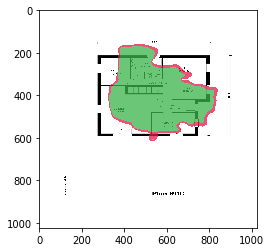

In [5]:
model = keras.models.load_model('./Unet_epoch_90.h5_noaug_epoch_90.h5')

21/21 [==============================] - 2s 95ms/step


True

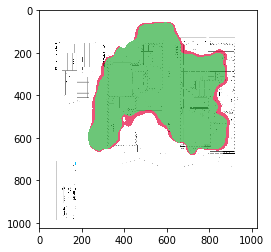

In [7]:
pred = model.predict(X_val, batch_size=None, verbose=1, steps=None)

In [ ]:
# resize to original

k = 12
p = pred[k,:,:]
p_original = skimage.transform.resize(p, val_size[k,:], order=0, mode='reflect', cval=0)
label = spacexyz.onehot2ind(p_original)
segmap = label.astype(np.int32)
segmap = ia.SegmentationMapOnImage(segmap, shape=val_size[k,:], nb_classes=n_classes)
X_or = cv2.imread(join(train_image_path, train_images[k]))
plt.imshow(segmap.draw_on_image(X_or))
# cv2.imwrite('messigray.png',segmap.draw_on_image(X_val[k,:,:,:]))

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa

one_hot = spacexyz.onehot2ind(pred)

k=10
label = one_hot[k,:,:]
segmap = label.astype(np.int32)
segmap = ia.SegmentationMapOnImage(segmap, shape=(1024, 1024), nb_classes=1+6)
plt.imshow(segmap.draw_on_image(X_val[k,:,:,:]))
cv2.imwrite('messigray.png',segmap.draw_on_image(X_val[k,:,:,:]))